<a href="https://colab.research.google.com/github/Badslam/COVID-Net/blob/master/rg_covid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Dependencies

In [ ]:
!pip install openpyxl
!pip install imutils
!pip install kaggle
!pip install patool

In [ ]:
# import the necessary packages
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imutils import paths
from google.colab import files
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import numpy as np
import shutil
import cv2
import os
import patoolib

print(tf.__version__)

2.5.0


In [ ]:
tf.random.set_seed(666)

# Dataset Preparation

In [ ]:
if not os.path.exists(os.getcwd() + "/kaggle.json"):
    files.upload()
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download tawsifurrahman/covid19-radiography-database

# extract riceleafs dataset
if os.path.exists(os.getcwd() + "/input"):
  shutil.rmtree(os.getcwd() + "/input")
patoolib.extract_archive(os.getcwd() + "/covid19-radiography-database.zip", outdir = os.getcwd() + "/input/covid19-radiography-database")
os.remove(os.getcwd() + "/covid19-radiography-database.zip")

mkdir: cannot create directory ‘/root/.kaggle’: File exists
100% 745M/745M [00:04<00:00, 143MB/s]

patool: Extracting /content/covid19-radiography-database.zip ...
patool: running /usr/bin/7z x -o/content/input/covid19-radiography-database -- /content/covid19-radiography-database.zip
patool: ... /content/covid19-radiography-database.zip extracted to `/content/input/covid19-radiography-database'.


In [ ]:
output_class = 2 # 2/3 class
if output_class > 3 or output_class < 2:
    print("Undefined")

if os.path.exists(os.getcwd() + "/Dataset"):
    shutil.rmtree(os.getcwd() + "/Dataset")
os.mkdir(os.getcwd() + "/Dataset")
os.mkdir(os.getcwd() + "/Dataset/Normal")
os.mkdir(os.getcwd() + "/Dataset/COVID")
if output_class == 3:
    os.mkdir(os.getcwd() + "/Dataset/Pneumonia")

In [ ]:
df = pd.read_excel(os.getcwd() + "/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal.metadata.xlsx", engine = "openpyxl")
df_normal = df[(df["URL"] == "https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia")]["FILE NAME"]

list_normal = np.array(df_normal)
list_normal[:] = [s.capitalize() for s in list_normal]
print(list_normal)

df = pd.read_excel(os.getcwd() + "/input/covid19-radiography-database/COVID-19_Radiography_Dataset/COVID.metadata.xlsx", engine = "openpyxl")
df_covid = df[(df["URL"] == "https://sirm.org/category/senza-categoria/covid-19/") | (df["URL"] == "https://github.com/ml-workgroup/covid-19-image-repository/tree/master/png") | (df["URL"] == "https://eurorad.org") | (df["URL"] == "https://github.com/armiro/COVID-CXNet") | (df["URL"] == "https://github.com/ieee8023/covid-chestxray-dataset")]["FILE NAME"]

list_covid = np.array(df_covid)
print(list_covid)

if output_class == 3:
    df = pd.read_excel(os.getcwd() + "/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Viral Pneumonia.metadata.xlsx", engine = "openpyxl")
    df_pneumonia = df["FILE NAME"]

    list_pneumonia = np.array(df_pneumonia)
    print(list_pneumonia)

['Normal-8852' 'Normal-8853' 'Normal-8854' ... 'Normal-10190'
 'Normal-10191' 'Normal-10192']
['COVID-1' 'COVID-2' 'COVID-3' ... 'COVID-1140' 'COVID-1141' 'COVID-1142']


In [ ]:
#dataset_covid = len(list_covid)
#dataset_normal = len(list_normal)
dataset_covid = 1000
dataset_normal = 1000
if output_class == 3:
    dataset_pneumonia = len(list_pneumonia)
    dataset_covid = 1000
    dataset_normal = 1000
    dataset_pneumonia = 1000

for x in range(dataset_normal):
    shutil.copyfile(os.getcwd() + "/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/{}{}".format(list_normal[x], ".png"), 
                    os.getcwd() + "/Dataset/Normal/{}{}".format(list_normal[x], ".png"))
for x in range(dataset_covid):
    shutil.copyfile(os.getcwd() + "/input/covid19-radiography-database/COVID-19_Radiography_Dataset/COVID/{}{}".format(list_covid[x], ".png"), 
                    os.getcwd() + "/Dataset/COVID/{}{}".format(list_covid[x], ".png"))
if output_class == 3:
    for x in range(dataset_pneumonia):
        shutil.copyfile(os.getcwd() + "/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Viral Pneumonia/{}{}".format(list_pneumonia[x], ".png"), 
                        os.getcwd() + "/Dataset/Pneumonia/{}{}".format(list_pneumonia[x], ".png"))

print("Dataset")
print("Normal :", len(os.listdir(os.getcwd() + "/Dataset/Normal")))
print("COVID :", len(os.listdir(os.getcwd() + "/Dataset/COVID")))
if output_class == 3:
    print("Pneumonia :", len(os.listdir(os.getcwd() + "/Dataset/Pneumonia")))

Dataset
Normal : 500
COVID : 500


# Plot X-Rays

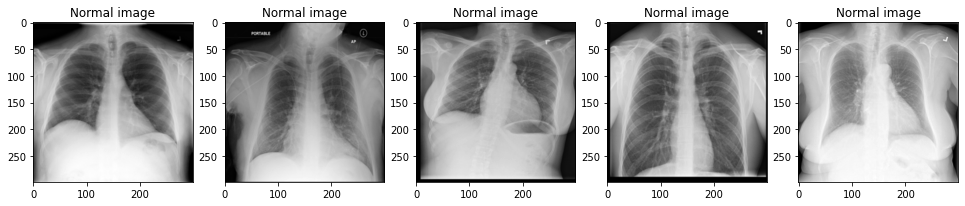

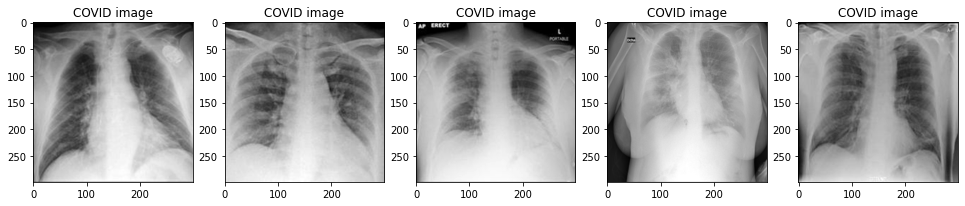

In [ ]:
directory = ["Normal", "COVID"]
if output_class == 3:
    directory = ["Normal", "COVID", "Pneumonia"]
for each in directory:
    plt.figure(figsize = (20, 10))
    currentFolder = os.getcwd() + "/Dataset/" + each
    for i, file in enumerate(os.listdir(currentFolder)[0:5]):
        fullpath = currentFolder + "/" + file
        img=mpimg.imread(fullpath)
        plt.subplot(3, 6, i+1)
        title = each + " image"
        plt.title(title)
        plt.imshow(img, cmap = 'gray')

# Data Preprocessing

In [ ]:
# set the initial learning rate, number of epochs, batch size and img dimension
learning_rate = 1e-3
epochs = 300
batch_size = 8
img_width, img_height = 224, 224
image_data_dir = os.getcwd() + "/Dataset"

# initialize the training and validation data augmentation
image_datagen = ImageDataGenerator(
    rescale = 1./255,
    validation_split = 0.2,
    rotation_range = 45,
    fill_mode = "nearest")

# set as training data
train_generator = image_datagen.flow_from_directory(
    image_data_dir,
    target_size = (img_width, img_height),
    class_mode = 'binary',
    batch_size = batch_size,
    subset = 'training')
# set as validation data
validation_generator = image_datagen.flow_from_directory(
    image_data_dir,
    target_size = (img_width, img_height),
    class_mode = 'binary',
    batch_size = batch_size,
    subset = 'validation')

# Build and Training Model

In [ ]:
# create model
if output_class == 2:
    model = tf.keras.Sequential([
        # Block 1
        tf.keras.layers.Conv2D(64, (3, 3), activation = "relu", padding = "same", input_shape = (img_width, img_height, 3)),
        tf.keras.layers.Conv2D(64, (3, 3), activation = "relu", padding = "same"),
        tf.keras.layers.Conv2D(64, (3, 3), activation = "relu", padding = "same"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(2, 2),

        # Block 2
        tf.keras.layers.Conv2D(128, (3, 3), activation = "relu", padding = "same"),
        tf.keras.layers.Conv2D(128, (3, 3), activation = "relu", padding = "same"),
        tf.keras.layers.Conv2D(128, (3, 3), activation = "relu", padding = "same"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(2, 2),
    
        # Block 3
        tf.keras.layers.Conv2D(256, (3, 3), activation = "relu", padding = "same"),
        tf.keras.layers.Conv2D(256, (3, 3), activation = "relu", padding = "same"),
        tf.keras.layers.Conv2D(256, (3, 3), activation = "relu", padding = "same"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(2, 2),
    
        # Block 4
        tf.keras.layers.Conv2D(512, (3, 3), activation = "relu", padding = "same"),
        tf.keras.layers.Conv2D(512, (3, 3), activation = "relu", padding = "same"),
        tf.keras.layers.Conv2D(512, (3, 3), activation = "relu", padding = "same"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(2, 2),
    
        # Block 5
        tf.keras.layers.Conv2D(1024, (3, 3), activation = "relu", padding = "same"),
        tf.keras.layers.Conv2D(1024, (3, 3), activation = "relu", padding = "same"),
        tf.keras.layers.Conv2D(1024, (3, 3), activation = "relu", padding = "same"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(2, 2),

        # Block 6
        tf.keras.layers.AveragePooling2D(4, 4),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation = "relu"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1, activation = "sigmoid")],
        name = "CNN_Binary_Classification")
    
    # compile our model
    model.compile(optimizer = Adam(learning_rate = learning_rate, decay = learning_rate / epochs),
                  loss = 'binary_crossentropy',
                  metrics = ['accuracy'])
        
elif output_class == 3:
    model = tf.keras.Sequential([
        # Block 1
        tf.keras.layers.Conv2D(64, (3, 3), activation = "relu", padding = "same", input_shape = (img_width, img_height, 3)),
        tf.keras.layers.Conv2D(64, (3, 3), activation = "relu", padding = "same"),
        tf.keras.layers.Conv2D(64, (3, 3), activation = "relu", padding = "same"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(2, 2),

        # Block 2
        tf.keras.layers.Conv2D(128, (3, 3), activation = "relu", padding = "same"),
        tf.keras.layers.Conv2D(128, (3, 3), activation = "relu", padding = "same"),
        tf.keras.layers.Conv2D(128, (3, 3), activation = "relu", padding = "same"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(2, 2),
    
        # Block 3
        tf.keras.layers.Conv2D(256, (3, 3), activation = "relu", padding = "same"),
        tf.keras.layers.Conv2D(256, (3, 3), activation = "relu", padding = "same"),
        tf.keras.layers.Conv2D(256, (3, 3), activation = "relu", padding = "same"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(2, 2),
    
        # Block 4
        tf.keras.layers.Conv2D(512, (3, 3), activation = "relu", padding = "same"),
        tf.keras.layers.Conv2D(512, (3, 3), activation = "relu", padding = "same"),
        tf.keras.layers.Conv2D(512, (3, 3), activation = "relu", padding = "same"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(2, 2),
    
        # Block 5
        tf.keras.layers.Conv2D(1024, (3, 3), activation = "relu", padding = "same"),
        tf.keras.layers.Conv2D(1024, (3, 3), activation = "relu", padding = "same"),
        tf.keras.layers.Conv2D(1024, (3, 3), activation = "relu", padding = "same"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(2, 2),

        # Block 6
        tf.keras.layers.AveragePooling2D(4, 4),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation = "relu"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(3, activation = "softmax")],
        name = "CNN_Multiclass_Classification")
    
    # compile our model
    model.compile(optimizer = Adam(learning_rate = learning_rate, decay = learning_rate / epochs),
                  loss = 'categorical_crossentropy',
                  metrics = ['accuracy'])
        
else:
    print("Undefined")

model.summary()

Model: "CNN_Binary_Classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
batch_normalization (BatchNo (None, 224, 224, 64)      256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 112, 

In [ ]:
# train the head of the network
result = model.fit(train_generator,
                   steps_per_epoch = train_generator.samples // batch_size,
                   validation_data = validation_generator,
                   validation_steps = validation_generator.samples // batch_size,
                   epochs = epochs)

Epoch 1/300
100/100 [==============================] - 33s 253ms/step - loss: 0.8242 - accuracy: 0.5875 - val_loss: 18.7548 - val_accuracy: 0.5000
Epoch 2/300
100/100 [==============================] - 26s 263ms/step - loss: 0.7829 - accuracy: 0.5725 - val_loss: 2.1725 - val_accuracy: 0.4950
Epoch 3/300
100/100 [==============================] - 26s 261ms/step - loss: 0.7432 - accuracy: 0.5938 - val_loss: 1.4499 - val_accuracy: 0.4850
Epoch 4/300
100/100 [==============================] - 25s 251ms/step - loss: 0.7877 - accuracy: 0.5750 - val_loss: 2.5784 - val_accuracy: 0.5000
Epoch 5/300
100/100 [==============================] - 26s 258ms/step - loss: 0.6755 - accuracy: 0.6700 - val_loss: 0.8887 - val_accuracy: 0.5850
Epoch 6/300
100/100 [==============================] - 26s 256ms/step - loss: 0.7685 - accuracy: 0.5813 - val_loss: 0.7073 - val_accuracy: 0.6050
Epoch 7/300
100/100 [==============================] - 26s 260ms/step - loss: 0.6963 - accuracy: 0.6012 - val_loss: 0.6305 

# Plot Result

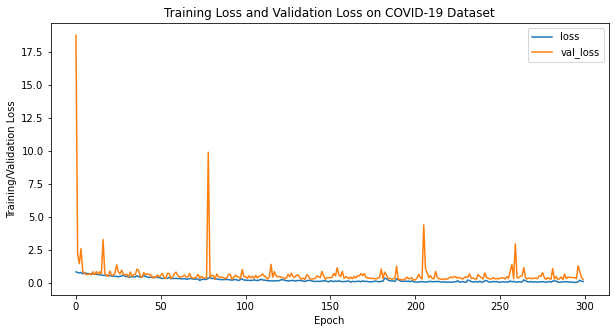

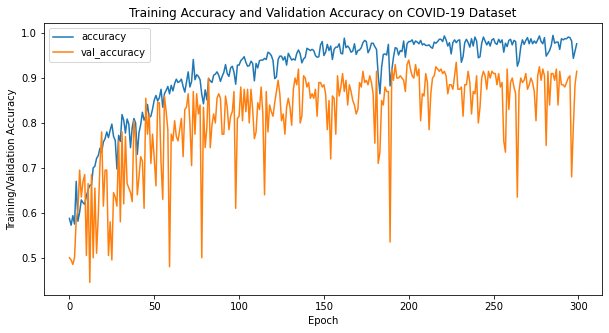

In [ ]:
# Plotting train_loss vs val_loss
plt.figure(figsize = (10, 5))
plt.plot(result.history["loss"], label = "loss")
plt.plot(result.history["val_loss"], label = "val_loss")
plt.title("Training Loss and Validation Loss on COVID-19 Dataset")
plt.xlabel("Epoch")
plt.ylabel("Training/Validation Loss")
plt.legend()

# Plotting train_accuracy vs Val_accuracy
plt.figure(figsize = (10, 5))
plt.plot(result.history["accuracy"], label = "accuracy")
plt.plot(result.history["val_accuracy"], label = "val_accuracy")
plt.title("Training Accuracy and Validation Accuracy on COVID-19 Dataset")
plt.xlabel("Epoch")
plt.ylabel("Training/Validation Accuracy")
plt.legend(loc = 'upper left')

# Evaluation

In [ ]:
#Prediction:
if output_class == 2:
    predict = model.predict_classes(validation_generator)
elif output_class == 3:
    predict = model.predict(validation_generator)
    predict = np.argmax(predict, axis=1)
else:
    print("Undefined")
    
print('Confusion Matrix')
if output_class == 2:
    print(confusion_matrix(validation_generator.classes, predict))
elif output_class == 3:
    print(confusion_matrix(validation_generator.classes.argmax(axis=1), predict))
else:
    print("Undefined")
    
print('Classification Report')
target_names = ['Normal', 'COVID']
if output_class == 3:
    target_names = ['Normal', 'COVID', 'Pneumonia']
if output_class == 2:
    print(classification_report(validation_generator.classes, predict, target_names = target_names))
elif output_class == 3:
    print(classification_report(validation_generator.classes.argmax(axis=1), predict, target_names = target_names))
else:
    print("Undefined")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Confusion Matrix
[[90 10]
 [ 7 93]]
Classification Report
              precision    recall  f1-score   support

      Normal       0.93      0.90      0.91       100
       COVID       0.90      0.93      0.92       100

    accuracy                           0.92       200
   macro avg       0.92      0.92      0.91       200
weighted avg       0.92      0.92      0.91       200



In [ ]:
# compute the confusion matrix and and use it to derive the raw accuracy, sensitivity, and specificity
print('Confusion Matrix')
if output_class == 2:
    cm = confusion_matrix(validation_generator.classes, predict)
elif output_class == 3:
    cm = confusion_matrix(validation_generator.classes.argmax(axis=1), predict)
else:
    print("Undefined")

total = sum(sum(cm))

# show the confusion matrix, accuracy, sensitivity, and specificity    
if output_class == 2:
    print(cm)
    acc = (cm[0][0] + cm[1][1]) / total
    print("acc: {:.4f}".format(acc))
    sensitivity = cm[0][0] / (cm[0][0] + cm[0][1])
    print("{} sensitivity: {:.4f}".format(target_names[0], sensitivity))
    sensitivity = cm[1][1] / (cm[1][0] + cm[1][1])
    print("{} sensitivity: {:.4f}".format(target_names[1], sensitivity))
elif output_class == 3:
    print(cm)
    acc = (cm[0][0] + cm[1][1] + cm[2][2]) / total
    print("acc: {:.4f}".format(acc))
    sensitivity = cm[0][0] / (cm[0][0] + cm[0][1] + cm[0][2])
    print("{} sensitivity: {:.4f}".format(target_names[0], sensitivity))
    sensitivity = cm[1][1] / (cm[1][0] + cm[1][1] + cm[1][2])
    print("{} sensitivity: {:.4f}".format(target_names[1], sensitivity))
    sensitivity = cm[2][2] / (cm[2][0] + cm[2][1] + cm[2][2])
    print("{} sensitivity: {:.4f}".format(target_names[2], sensitivity))
else:
    print("Undefined")

Confusion Matrix
[[90 10]
 [ 7 93]]
acc: 0.9150
Normal sensitivity: 0.9000
COVID sensitivity: 0.9300


In [ ]:
print("Loss")
print(result.history["loss"])
print("Accuracy")
print(result.history["accuracy"])
print("Val_Loss")
print(result.history["val_loss"])
print("Val_Accuracy")
print(result.history["val_accuracy"])

Loss
[0.8242304921150208, 0.782905101776123, 0.7432324886322021, 0.7877100110054016, 0.6755375862121582, 0.7684851288795471, 0.6962613463401794, 0.7079748511314392, 0.6621456146240234, 0.6958394050598145, 0.664519190788269, 0.6459187865257263, 0.6458137631416321, 0.6159002184867859, 0.6098149418830872, 0.5956442356109619, 0.5587527751922607, 0.5617192983627319, 0.5428333282470703, 0.5403487682342529, 0.5410707592964172, 0.5146076679229736, 0.49585095047950745, 0.49741482734680176, 0.4812926948070526, 0.4509703516960144, 0.4908064007759094, 0.5085233449935913, 0.5924386978149414, 0.4741159677505493, 0.4863516688346863, 0.41472575068473816, 0.43742257356643677, 0.4674604833126068, 0.43599873781204224, 0.45317190885543823, 0.5359784364700317, 0.4567970037460327, 0.4130937159061432, 0.4426891803741455, 0.5529731512069702, 0.476942241191864, 0.4477359354496002, 0.3993534743785858, 0.42510899901390076, 0.409239798784256, 0.3860023617744446, 0.40900376439094543, 0.41156092286109924, 0.3901235